In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt
from keras.layers import Conv1D, RNN, Embedding, SimpleRNN, Dense

from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Attention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

In [2]:
data = pd.read_csv('processed_data.csv')
data

,target,text
0,0,awww that's bummer. shoulda got david carr day...
1,0,upset can't update facebook texting it... resu...
2,0,dived times ball. managed save 50 rest bounds
3,0,body feels itchy like
4,0,it's behaving all. i'm mad. can't there.
...,...,...
1599995,4,woke up. having school best feeling
1599996,4,thewdb.com cool hear old walt interviews
1599997,4,ready mojo makeover ask details
1599998,4,happy 38th birthday boo alll tears eyes tupac ...


In [3]:
data = shuffle(data, random_state=42).reset_index(drop=True)
data['target'] = data['target'].apply(lambda x: 0 if x == 0 else 1)

In [4]:
X = data['text'].tolist()
Y = data['target'].tolist()
Y

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [6]:
X_train = [str(text) for text in X_train if isinstance(text, (str, float))]
X_test = [str(text) for text in X_test if isinstance(text, (str, float))]

In [7]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [8]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [9]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

322144

In [10]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [11]:
embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [12]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(322144, 100)

In [15]:
type(embedding_matrix)
np.savetxt('embedding_matrix_lstm.csv', embedding_matrix, delimiter=',')

----------
SAVED
_________

In [ ]:
loaded_embedding_matrix = np.loadtxt('embedding_matrix_lstm.csv', delimiter=',')

In [27]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [28]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          32214400  
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 32,224,401
Trainable params: 10,001
Non-trainable params: 32,214,400
_________________________________________________________________
None


In [29]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
8000/8000 [==============================] - 22s 3ms/step - loss: 0.5940 - acc: 0.6857 - val_loss: 0.5898 - val_acc: 0.6899
Epoch 2/6
8000/8000 [==============================] - 23s 3ms/step - loss: 0.5903 - acc: 0.6896 - val_loss: 0.5896 - val_acc: 0.6917
Epoch 3/6
8000/8000 [==============================] - 23s 3ms/step - loss: 0.5903 - acc: 0.6897 - val_loss: 0.5891 - val_acc: 0.6924
Epoch 4/6
8000/8000 [==============================] - 22s 3ms/step - loss: 0.5901 - acc: 0.6901 - val_loss: 0.5892 - val_acc: 0.6913
Epoch 5/6
8000/8000 [==============================] - 22s 3ms/step - loss: 0.5902 - acc: 0.6901 - val_loss: 0.5900 - val_acc: 0.6905
Epoch 6/6
8000/8000 [==============================] - 22s 3ms/step - loss: 0.5901 - acc: 0.6903 - val_loss: 0.5904 - val_acc: 0.6911


In [30]:
score = snn_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

10000/10000 [==============================] - 22s 2ms/step - loss: 0.5903 - acc: 0.6906
Test Score: 0.5903201699256897
Test Accuracy: 0.6905875205993652


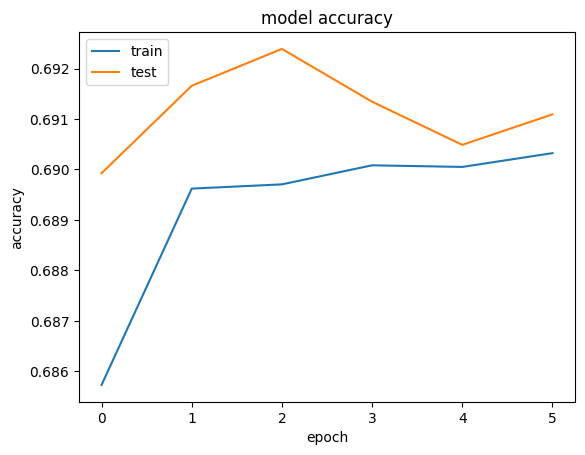

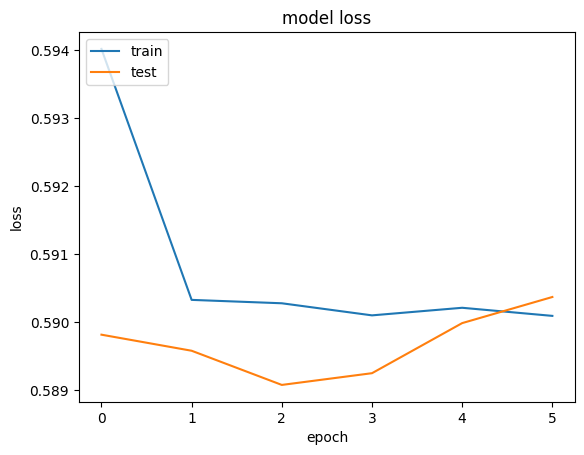

In [32]:

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [34]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [35]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          32214400  
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 32,278,657
Trainable params: 64,257
Non-trainable params: 32,214,400
_________________________________________________________________
None


In [36]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
8000/8000 [==============================] - 29s 3ms/step - loss: 0.5205 - acc: 0.7382 - val_loss: 0.5043 - val_acc: 0.7489
Epoch 2/6
8000/8000 [==============================] - 25s 3ms/step - loss: 0.4952 - acc: 0.7565 - val_loss: 0.4982 - val_acc: 0.7549
Epoch 3/6
8000/8000 [==============================] - 25s 3ms/step - loss: 0.4841 - acc: 0.7642 - val_loss: 0.5009 - val_acc: 0.7520
Epoch 4/6
8000/8000 [==============================] - 25s 3ms/step - loss: 0.4761 - acc: 0.7695 - val_loss: 0.4966 - val_acc: 0.7558
Epoch 5/6
8000/8000 [==============================] - 25s 3ms/step - loss: 0.4703 - acc: 0.7732 - val_loss: 0.5034 - val_acc: 0.7519
Epoch 6/6
8000/8000 [==============================] - 25s 3ms/step - loss: 0.4654 - acc: 0.7768 - val_loss: 0.5040 - val_acc: 0.7525


In [37]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5903201699256897
Test Accuracy: 0.6905875205993652


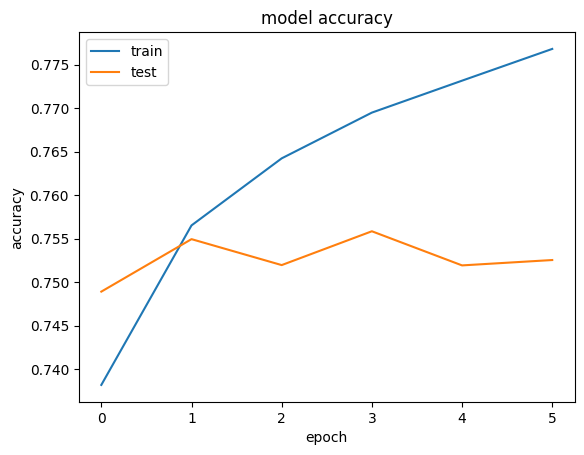

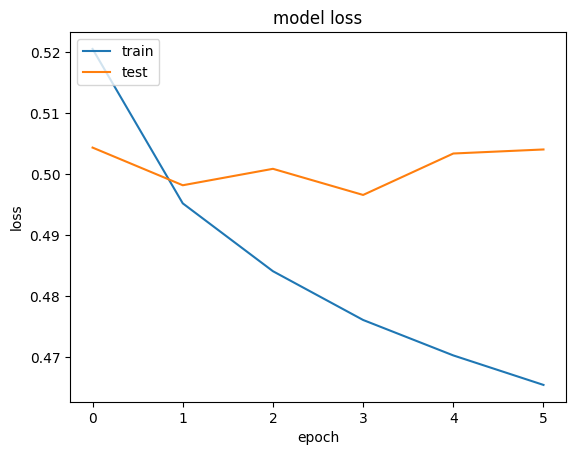

In [38]:
plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [43]:
rnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
rnn_model.add(embedding_layer)

rnn_model.add(SimpleRNN(128))

rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          32214400  
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 32,243,841
Trainable params: 29,441
Non-trainable params: 32,214,400
_________________________________________________________________


In [44]:
rnn_model_history = rnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
8000/8000 [==============================] - 558s 70ms/step - loss: 0.6933 - accuracy: 0.5047 - val_loss: 0.6935 - val_accuracy: 0.4994
Epoch 2/6
8000/8000 [==============================] - 555s 69ms/step - loss: 0.6941 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5007
Epoch 3/6
8000/8000 [==============================] - 537s 67ms/step - loss: 0.6943 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.4991
Epoch 4/6
8000/8000 [==============================] - 538s 67ms/step - loss: 0.6944 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 5/6
8000/8000 [==============================] - 541s 68ms/step - loss: 0.6944 - accuracy: 0.5002 - val_loss: 0.6944 - val_accuracy: 0.4985
Epoch 6/6
8000/8000 [==============================] - 539s 67ms/step - loss: 0.6944 - accuracy: 0.5017 - val_loss: 0.6960 - val_accuracy: 0.5038


In [45]:
score = rnn_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

10000/10000 [==============================] - 167s 17ms/step - loss: 0.6960 - accuracy: 0.5040
Test Score: 0.6959621906280518
Test Accuracy: 0.5039593577384949


In [18]:
lstm_model = Sequential()

# Embedding layer (use pre-trained embeddings like GloVe or FastText, fine-tune during training)
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
lstm_model.add(embedding_layer)

# Bidirectional LSTM Layer (captures context from both ends of the sentence)
lstm_model.add(Bidirectional(LSTM(128, return_sequences=True)))

# Attention Layer (self-attention)
# Pass the same tensor as both query and value
attention_output = Attention()([lstm_model.output, lstm_model.output])

# Global Average Pooling to reduce the output dimensionality
lstm_model.add(GlobalAveragePooling1D())

# Dropout Layer (regularization to prevent overfitting)
lstm_model.add(Dropout(0.5))

# Dense Layer (final classification layer)
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

In [19]:
lstm_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          32214400  
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 256)         234496    
 nal)                                                            
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)               

In [20]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
8000/8000 [==============================] - 176s 21ms/step - loss: 0.5489 - accuracy: 0.7216 - val_loss: 0.5175 - val_accuracy: 0.7401
Epoch 2/6
8000/8000 [==============================] - 205s 26ms/step - loss: 0.5178 - accuracy: 0.7452 - val_loss: 0.5101 - val_accuracy: 0.7458
Epoch 3/6
8000/8000 [==============================] - 202s 25ms/step - loss: 0.5094 - accuracy: 0.7511 - val_loss: 0.5008 - val_accuracy: 0.7515
Epoch 4/6
8000/8000 [==============================] - 199s 25ms/step - loss: 0.5039 - accuracy: 0.7546 - val_loss: 0.4952 - val_accuracy: 0.7555
Epoch 5/6
8000/8000 [==============================] - 190s 24ms/step - loss: 0.4999 - accuracy: 0.7569 - val_loss: 0.4944 - val_accuracy: 0.7559
Epoch 6/6
8000/8000 [==============================] - 139s 17ms/step - loss: 0.4962 - accuracy: 0.7597 - val_loss: 0.4939 - val_accuracy: 0.7572


In [21]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

10000/10000 [==============================] - 63s 6ms/step - loss: 0.4935 - accuracy: 0.7575


In [22]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.49354448914527893
Test Accuracy: 0.7575093507766724


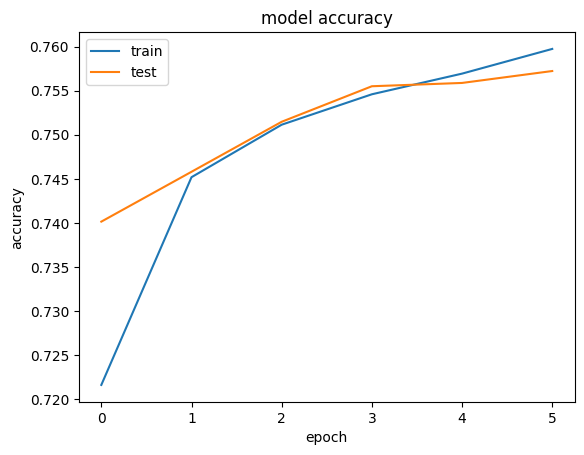

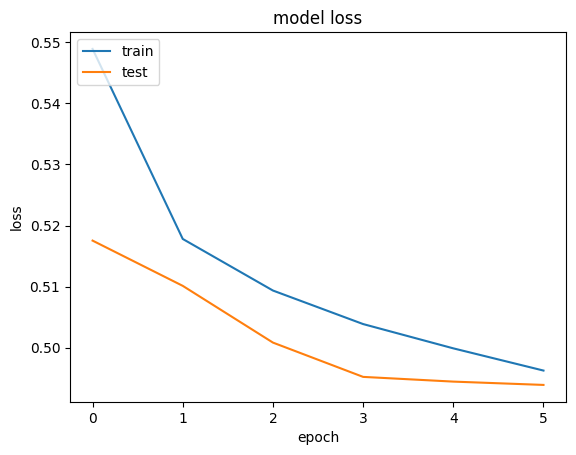

In [26]:
plt.plot(lstm_model_history.history['accuracy'])
plt.plot(lstm_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Attention, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    # Define the model architecture
    lstm_model = Sequential()

    # Embedding layer (use pre-trained embeddings like GloVe or FastText, fine-tune during training)
    embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
    lstm_model.add(embedding_layer)

    # Bidirectional LSTM Layer (captures context from both ends of the sentence)
    lstm_model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units', min_value=128, max_value=240, step=32), 
        return_sequences=True)))

    # Attention Layer (self-attention)
    attention_output = Attention()([lstm_model.output, lstm_model.output])

    # Global Average Pooling to reduce the output dimensionality
    lstm_model.add(GlobalAveragePooling1D())

    # Dropout Layer (regularization to prevent overfitting)
    lstm_model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)))

    # Dense Layer (final classification layer)
    lstm_model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=180, step=32),
        activation='relu'))
    lstm_model.add(Dropout(rate=hp.Float('dropout_rate_2', min_value=0.2, max_value=0.7, step=0.1)))
    lstm_model.add(Dense(1, activation='sigmoid'))

    # Compile the model with an optimizer
    lstm_model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',  # Use binary crossentropy for binary classification tasks
        metrics=['accuracy']
    )

    return lstm_model

# Define the tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of trials to run
    executions_per_trial=1,  # Run each trial once
    directory='my_dir_2',  # Save results here
    project_name='lstm_bayesian_tuning_2'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=2)

# Get the best hyperparameterss
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hp.values}")



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
224               |224               |lstm_units
0.2               |0.2               |dropout_rate
96                |96                |dense_units
0.3               |0.3               |dropout_rate_2
0.00015418        |0.00015418        |learning_rate

Epoch 1/2
 1437/40000 [>.............................] - ETA: 10:08 - loss: 0.6052 - accuracy: 0.6783

In [14]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('best_lstm_model.h5')

Best Hyperparameters: {'lstm_units': 192, 'dropout_rate': 0.5, 'dense_units': 128, 'dropout_rate_2': 0.30000000000000004, 'learning_rate': 0.0010872353209015178}